# Convolutional Neural Network - Binary Classfication


#### Intro to binary CNN
https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa

#### Code inspiration from here..

https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697 


In [1]:
# Libraries that might be installed beforehand

#!pip install opencv-python
#!pip install sklearn

In [2]:
# Default Libraries
import pandas as pd
import tensorflow as tf
import numpy as np

# CNN Envrionment
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub

%load_ext tensorboard

# Plotting Libraries
import matplotlib.pyplot as plt

# Miscellaneous
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import os
import shutil
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Python Scripts
import sys  
sys.path.insert(0, './Python_Scripts')

import util

In [3]:
# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

2.7.0


In [4]:
# Load Data
df = pd.read_csv('Data/train_complete.csv')
df.head(2)

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/michael/neuefische/CapstoneProject_Stee...,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/michael/neuefische/CapstoneProject_Stee...,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1


## Convert from RGB to Gray-Scale:

To speed up the process you can convert the RGB pics to gray-scaled. This is from accuracy perspective not necessary.

https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale

In [5]:
# Grey-Scaling
original =  plt.imread('./Data/train_images/' + str(df.ImageId[0]))

converted = tf.image.rgb_to_grayscale(original)

print(original.shape)
print(converted.shape)

Metal device set to: Apple M1
(256, 1600, 3)
(256, 1600, 1)


2022-02-25 14:03:29.801071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-25 14:03:29.801151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Text(0.5, 1.0, 'Grey-Scaled')

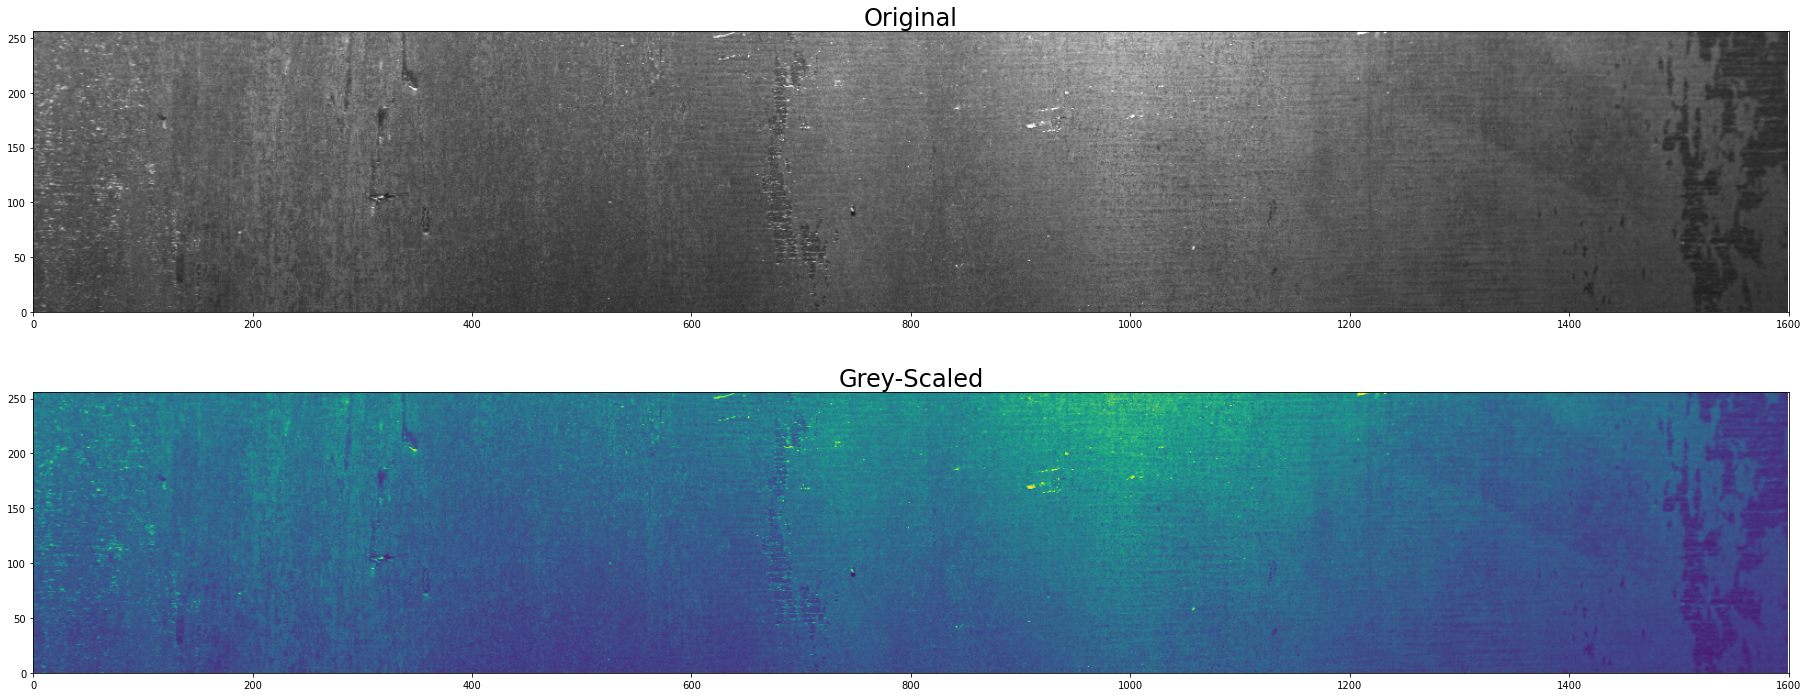

In [6]:
# Figure as subplots
fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(25, 10))

# Subplot 1
plt.subplot(2, 1, 1)
plt.imshow(original)
plt.xlim(0,1600)
plt.ylim(0,256)
ax[0].set_title('Original', fontsize= 24)


# Subplot 2
plt.subplot(2, 1, 2)
plt.imshow(converted)
plt.xlim(0,1600) 
plt.ylim(0,256)
ax[1].set_title('Grey-Scaled', fontsize= 24)

## Test Split and Data Storage Preparation

In [7]:
 # Do the test split
#index = df.ClassId == 3 
#df = df[index] 
df_red = df.query('Defect == 1')
util.isolate_single_defects(df_red)

X = df_red.iloc[:,0:4]
y = df_red.iloc[:,2]

df_red.loc[df['ClassId'] == 1,'ClassId'] = 0
df_red.loc[df['ClassId'] == 2,'ClassId'] = 0
df_red.loc[df['ClassId'] == 3,'ClassId'] = 1
df_red.loc[df['ClassId'] == 4,'ClassId'] = 0

./Python_Scripts/util.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(indices, inplace=True)


In [8]:
df_red.head()

,FilePath,ImageId,ClassId,EncodedPixels,Defect
0,/Users/michael/neuefische/CapstoneProject_Stee...,0002cc93b.jpg,0,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,/Users/michael/neuefische/CapstoneProject_Stee...,0007a71bf.jpg,1,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,/Users/michael/neuefische/CapstoneProject_Stee...,000a4bcdd.jpg,0,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,/Users/michael/neuefische/CapstoneProject_Stee...,000f6bf48.jpg,0,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,/Users/michael/neuefische/CapstoneProject_Stee...,0014fce06.jpg,1,229501 11 229741 33 229981 55 230221 77 230468...,1


In [9]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state = 1)
length_train = len(y_train)
length_test = len(y_test)
print('Length of Train-Set: ' + str(len(y_train)))
print('Length of Test-Set: ' + str(len(y_test)))

Length of Train-Set: 4367
Length of Test-Set: 1872


In [10]:
# Check No-Defect Distributions
print('No-Defect-Ratio in Train: ' + str(round((y_train == 0).astype(int).sum(axis=0) / len(y_train),4)))
print('No-Defect-Ratio in Test: ' + str(round((y_test == 0).astype(int).sum(axis=0) / len(y_test),4)))

No-Defect-Ratio in Train: 0.2372
No-Defect-Ratio in Test: 0.2372


In [11]:
# ConvertToGrayScale
def ConvertToGrayScale(file_name, input_path, target_path):
    #original =  plt.imread(input_path + file_name)
    original = tf.keras.utils.load_img(input_path + file_name, grayscale=False, color_mode='rgb', target_size=None)
    converted = tf.image.rgb_to_grayscale(original)
    tf.keras.utils.save_img(target_path + file_name, converted, data_format=None, file_format=None, scale=True)
    return 

In [12]:
# Excute ConvertToGrayScale Function
# Input path of the origin RGB images
input_path = './Data/train_images/'

# Set a target path where to save the gray-scaled images
target_path = './Data/train_images_GrayScaled/'

# Uncomment the loop if you want to work with gray scaled images
#for i in range(len(df.ImageId)):
#    file_name = df.ImageId[i]
#    ConvertToGrayScale(file_name, input_path, target_path)

In [13]:
# Create a temp path for the train & test split
def MakePathStructure():
    path = os.getcwd()
    
    ## You might need to adjust the path to your local environment
    temp_path = path + "/Data/Temp"
    
    # Make DirectoryTemp and Sub-Directories Train & Test
    # Adjust string names according your requirements
    try:
        #os.mkdir(temp_path)
        os.mkdir(temp_path + '/C1vsRemain_Train')
        os.mkdir(temp_path + '/C1vsRemain_Test')
        os.mkdir(temp_path + '/C1vsRemain_Train/C0')
        os.mkdir(temp_path + '/C1vsRemain_Train/C3')
        os.mkdir(temp_path + '/C1vsRemain_Test/C0')
        os.mkdir(temp_path + '/C1vsRemain_Test/C3')
            
    except OSError:
        return print ("Creation of the directories failed")
    else:
        return print ("Successfully created the directories")

In [14]:
# Execute Function If Test-Temp Folder Structure is not ready yet..
#MakePathStructure()

In [15]:
# Copy and Separate in Imgages in Test and Train Folder
def CopySeparateImagesToTestTrain():
    # Train Data
    path = os.getcwd()
    for i in range(len(X_train)):
        origin_train_path = path + '/Data/train_images/'
        source_file = X_train.iloc[i,1]
        
        #Seperate the classes into subfolders C0 and C1
        if y_train.iloc[i] == 0:
            target_directory = path + '/Data/Temp/C1vsRemain_Train/C0/'
        else:
            target_directory = path + '/Data/Temp/C1vsRemain_Train/C1/'
        # Copy The Files
        shutil.copy2(origin_train_path + source_file , target_directory + source_file)
        
    # Test Data
    for i in range(len(X_test)):
        origin_train_path = path + '/Data/train_images/'
        source_file = X_test.iloc[i,1]
        
        #Seperate the classes into subfolders C0 and C1
        if y_train.iloc[i] == 0:
            target_directory = path + '/Data/Temp/C1vsRemain_Test/C0/'
        else:
            target_directory = path + '/Data/Temp/C1vsRemain_Test/C1/'
        # Copy The Files
        shutil.copy2(origin_train_path + source_file , target_directory + source_file)

In [16]:
# Execute function if files needs to copied into the subfolders und splitted into the classes
#CopySeparateImagesToTestTrain()

## CNN Model Preparation

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/api/preprocessing/image/

In [17]:
# Get current working directory
path = os.getcwd()

# Normalize the color values between 0 and 1 and set augmentation for train generator
datagen = ImageDataGenerator(rescale=1/255,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
shear_range = 10,
horizontal_flip = True)


validation = ImageDataGenerator(rescale=1/255)
batch_size = 32
# Takes the path to a directory & generates batches of augmented data.
train_generator = datagen.flow_from_directory( path + '/Data/Temp/C3vsRemain_Train/',
                                          target_size=(128,800),   
                                          #color_mode='grayscale',
                                          batch_size = batch_size,
                                          seed = 1,
                                          class_mode = 'binary')

# Takes the path to a directory & generates batches of augmented data.
validation_generator = datagen.flow_from_directory(path + '/Data/Temp/C3vsRemain_Test/',
                                                  target_size=(128,800),
                                                  #color_mode='grayscale',
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  seed = 1
                                                  )

Found 4951 images belonging to 2 classes.
Found 2104 images belonging to 2 classes.


## Analysis Outcome From Image Generator

In [18]:
print('Data labels are separated in following binary code: ' + str(validation_generator.class_indices))

Data labels are separated in following binary code: {'C0': 0, 'C1': 1}


In [19]:
# validation_generator[..]
print(type(validation_generator))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [20]:
# Iterate and see the pictures and labels
img_batch, labels = next(validation_generator)
print('Shape of the input batch' + str(img_batch.shape))
print('Min of labels: ' + str(min(labels)) + ' and Max of labels: ' +str(max(labels)))

Shape of the input batch(32, 128, 800, 3)
Min of labels: 0.0 and Max of labels: 1.0


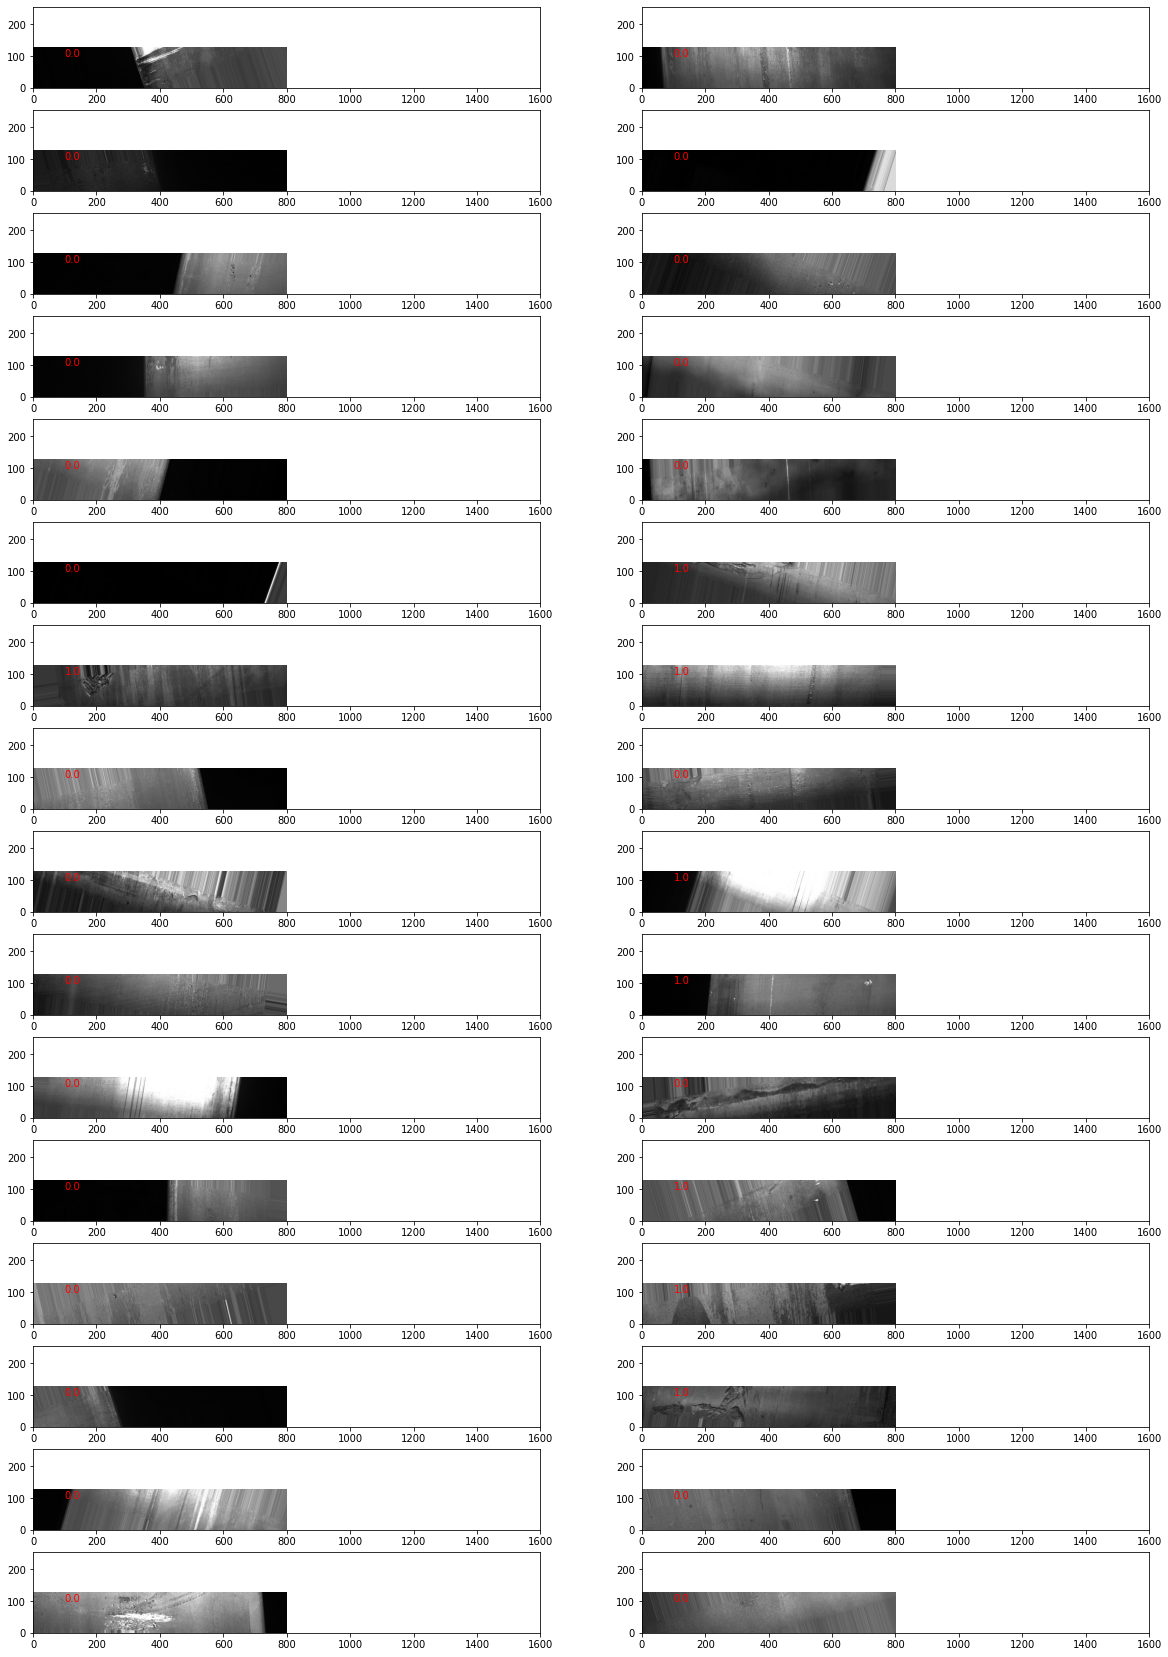

In [21]:
# Plot the image batch content
fig, ax = plt.subplots(int(len(img_batch) / 2), 2,constrained_layout=False)
                                                                            
for i in range(len(img_batch)):
    plt.subplot(int(len(img_batch) / 2), 2, i + 1)
    fig.set_figheight(30)
    fig.set_figwidth(20)
    plt.xlim(0,1600)
    plt.ylim(0,256)
    plt.imshow(img_batch[i])
    plt.text(100, 100, labels[i],color='r')
    
plt.show()

## First The Base Neural Network

https://keras.io/guides/sequential_model/

In [22]:
def CNN_model_base():
    model = keras.Sequential()
    
    
    # Convolutional layer 1: 
    # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    # Maybe increase the filter size e.g. 9x9
    model.add(keras.layers.Conv2D(16,(3,3), # 16 Filters and 3x3 Kernel
                                  activation='relu', 
                                  input_shape=(256,1600,1),
                                  strides = (3,3),
                                  padding="valid"))
    
    # Check more network structures --> 
    # Check Image After Rezising!!  
    #model.add(keras.layers.Resizing(int(256), int(1600), interpolation="bilinear", crop_to_aspect_ratio=True))
    
    #The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, 
    #which helps prevent overfitting.
    #model.add(Dropout(0.2))
    
    #MaxPooling makes network invariant to small translations
    model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2), padding="same")) 
    
    
    # Convolutional layer and maxpool layer 2
    model.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2), padding="same")) 
    
    # Convolutional layer and maxpool layer 3
    model.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2), padding="same")) 
    
    # Convolutional layer and maxpool layer 4
    model.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2), padding="same")) 
    
    # Convolutional layer and maxpool layer 5
    model.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2), padding="same")) 
     
    # This layer flattens resulting image array to 1D array
    model.add(keras.layers.Flatten())
    
    # Hidden layer 1: with XXX neurons and Rectified Linear Unit Activation Function 
    model.add(keras.layers.Dense(256,activation='relu'))
    
    # Hidden layer 2
    model.add(keras.layers.Dense(512,activation='relu'))
    
    # Hidden layer 3
    model.add(keras.layers.Dense(512,activation='relu'))
    
    # Output layer with single neuron which gives 0 for Non-Failure or 1 for Failure 
    #Here we use sigmoid activation function which makes our model output to lie between 0 and 1
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    return model

## Second CNN as VGG16 architecture
 You can choose whether to compute with the previous base architecture or the following VGG16

In [23]:
def VGG16_model():
    model_VGG16 = keras.Sequential()
    
    model_VGG16.add(Conv2D(input_shape=(128,800,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    #model_VGG16.add(keras.layers.Resizing(int(256/8), int(1600/8), interpolation="bilinear", crop_to_aspect_ratio=True))
    model_VGG16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model_VGG16.add(Flatten())
    model_VGG16.add(Dense(units=4096,activation="relu")) 
    model_VGG16.add(Dense(units=4096,activation="relu")) 
    
    model_VGG16.add(keras.layers.Dense(1,activation='sigmoid'))
    model = model_VGG16
    return model

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [24]:
# Choose one of the archtectures
#model = CNN_model_base()
model = VGG16_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 800, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 800, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 400, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 400, 128)      73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 400, 128)      147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 200, 128)     0         
 2D)                                                    

## Train The CNN

In [25]:
def train_model(model, batch_size, learning_rate, epochs):
# RMSprop: Maintain a moving (discounted) average of the square of gradients
# Divide the gradient by the root of this average
    opt = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    
     
    # Wie sehen die Labels der Loss-Funktion aus? Scalar? Hot-Encoding? Check Doku, was wird fuer binary_crossent. benoetigt
    #https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    model.compile(loss =tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = opt,
                  metrics = [tf.keras.metrics.Recall(), 'accuracy'])

    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#fit
    # You may need to implement seed in fit?
    history = model.fit(train_generator,
              steps_per_epoch = length_train // batch_size, # Number if images in train divided by batch size
              epochs = epochs,
              verbose = 1,
              validation_data = validation_generator,
              validation_steps = length_test // batch_size,
              callbacks=[tensorboard_callback]) 
    
    return model

In [ ]:
# Train model
trained_model = train_model(model, batch_size, learning_rate = 0.01, epochs = 5)
# If you like to save the model use following code..
#trained_model.save_weights('saved_binaryCNN_model.h5')

2022-02-25 14:04:00.884700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-02-25 14:04:01.811010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [ ]:
# Start the TensorBoard Notebook Extension
%tensorboard --logdir logs/fit

## Evaluate Model Performance

In [ ]:
# Evaluate The Model Accuracy
def evaluate_model(validation_generator):
    model.evaluate(validation_generator)
    return

In [ ]:
evaluate_model(validation_generator)

In [ ]:
# Delete the validation generator
#STEP_SIZE_TEST = validation_generator.n // validation_generator.batch_size
#validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)

##  __Notebooks__

|No.|Notebook| Brief Summary|
|---|---|---|
|1|first-EDA.ipynb| This notebook contains the exploritory data analysis regarding this project.|
|2|convert-to-mask.ipynb| TBD |
|3|FailurePostion.ipynb| This notebook generates pixels at specified position of failure encoding from the csv file. Aftwards it plots the image with and without defect in 2 subplots to compare real pattern and defect labelled area.|
|4|BinaryCNN.ipynb| Here you can find the binary classification model as Convolutional Neural Network(CNN). This notebook tooks the data from the challenge and do binary comparisons like e.g. Class 3 Vs. Remain Classes. It is setup as to use with KERAS generators and the required folder structure. The folder structure can be created with functions in the notebook.|
|5|Clustering.ipynb| Clustering is an unsupervised machine learning task. Here in this notebook it were analysed how this technique can enhence dataset from the unlabeled images.|
|6|HOG.ipynb|Here the Histogram of Oriented Gradients were calculated from the given images. |
|7|image-augmentation.ipynb|This notebook can be used to do the image augmentation. |
|8|isolate-defectless-images.ipynb|In this notebook the images without defect labelling can be isolated.|
|9|KNN-with-augmentet-images.ipynb|Here the k-Nearest-Neighbour algorithm were used to classify the images. The images were pre-processed with augmention. Means that the give data were multiplied|
|10|KNN-with-initial.ipynb.ipynb|In here the k-Nearest-Neighbour algorithm were used to classify the images. In this case the images were not pre-processed.|
|11|Model-with-HOG-SURF.ipynb|In this notebook the images are pre-processed either with HOG method or SURF.|
|12|segmentation_multi_model.ipynb|This is the key notebook of the CNN multi model generation. Here it is used the UNET model pre-trained to efficientnetb5 database. Finally the 4 models, one for each defect class will be calculated. Afterwards you can predict with single images the 4 models response mask.|
|13|segmentation_single_model.ipynb|This notebook is similar to the "segmentation_multi_model.ipynb", at least from model perspective. Also the pre-trained UNET model is the key to predict the masks of the images. Different here it especially setup to analyze the masks of a single model of one defect class.|
|14|SURF.ipynb | To analyze the images regarding the SURF(Speeded Up Robust Features) method you can use this notebook.|
|15| unstructered-data-handling.ipnyb |TBD|